In [372]:
%matplotlib notebook
import matplotlib as mpl
import itertools
import PyVal
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import ipyparallel as ipp
import seaborn as sns
import gzip
from tqdm import tqdm_notebook
from functools import reduce
NColors = 15
colors = sns.color_palette("husl",NColors)#sns.cubehelix_palette(12)#
from matplotlib.lines import Line2D
import matplotlib

In [7]:
idx = pd.IndexSlice
rc = ipp.Client()#('/home/julian/.ipython/profile_ssh/security/ipcontroller-client.json')
dview = rc.load_balanced_view()
print(rc.ids)
sns.set_style("whitegrid")

def send_file(dview, local_path, remote_path):
    """Send a single file"""
    print("sending file", local_path, remote_path)
    import io, os
    
    def _recv(remote_path, bdata, mtime):
        import io, os
        if os.path.exists(remote_path):
            os.unlink(remote_path)
        with io.open(remote_path, 'wb') as f:
            f.write(data)
        os.utime(remote_path, (mtime, mtime))
    
    st = os.stat(local_path)
    with io.open(local_path, 'rb') as f:
        data = f.read()
    
    yield dview.apply_async(_recv, remote_path, data, st.st_mtime)
    
#TODO: use chrpath PyVal.so -r . to make libtrng visible
#for el in send_file(dview, '../build/PyVal.cpython-36m-x86_64-linux-gnu.so','./PyVal.so'):
    
    print(el.get())
for el in send_file(dview, '../external/lib/libtrng4.so.19', './libtrng4.so.19'):
    pass
for el in send_file(dview, '../external/lib/libtrng4.so', './libtrng4.so'):
    pass

with rc[:].sync_imports():
    import PyVal
    import numpy as np


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
sending file ../external/lib/libtrng4.so.19 ./libtrng4.so.19
None
sending file ../external/lib/libtrng4.so ./libtrng4.so
None
importing PyVal on engine(s)
importing numpy on engine(s)


In [209]:
%run "functions.py"

# Parameters
## Black Scholes
    - T = 1
    - r = 0
    
## Network Parameters
    - N = [15, 25, 50, 75, 100, 150, 200, 300]
    - <k> = n*p = [0 .. 1.8]
    - M => ER(N,p)

In [344]:
Nsamples = 5000000
r  = 0.
T  = 1.
N_MC = 5000000
N = 2
df_scale = 1.0
netType = 1
vs01_vals = np.array([0.])#,0.2, 0.6, 0.8])
vs10_vals = np.array([0.])#,0.2, 0.6, 0.8])
vr01_vals = np.array([0.,0.2, 0.4, 0.6, 0.8])
vr10_vals = np.array([0.,0.2, 0.4, 0.6, 0.8])
S0_vals   = np.linspace(0., 2.0, 70)
sigma_vals = np.linspace(0.05, 0.4, 5)
r_vals    = [0.0]#[0., 0.1, 0.2]
T_vals    = [1.]#[0.1, 1.0, 2.0]
param_grid = [(N_MC, N, T, r, S0, sigma, df_scale, vs01, vs10, vr01, vr10) \
             for T in T_vals for r in r_vals for S0 in S0_vals for sigma in sigma_vals\
             for vs01 in vs01_vals for vs10 in vs10_vals for vr01 in vr01_vals for vr10 in vr10_vals]
len(param_grid)

4480

In [345]:
async_res = []
ids = []
for el in param_grid:
    with dview.temp_flags(retries=2):
        b_re = dview.apply_async(run_fixed_sim, *el)
        async_res.append(b_re)
        ids.extend(b_re.msg_ids)
filename = "param_grid_fixed2D_testSigma"

In [356]:
done = 0
waiting = 0
for el in async_res:
    if el.progress == 1:
        done += 1
    else:
        waiting += 1
print(str(done) + "/"+str(waiting+done) + " complete")
#param_grid_ER_no_suppression

4480/4480 complete


In [339]:
print('unfinished jobs: '+ str(len(rc.result_status(ids)['pending'])) + '/' + str(len(rc.result_status(ids)['completed']) + len(rc.result_status(ids)['pending'])) + str('. Running on ') + str(len(rc.ids)) + ' nodes')

unfinished jobs: 0/2560. Running on 96 nodes


In [357]:
f_content = [r.get() for r in async_res]
df = results_to_df(f_content, 1)
df2,df2_bak = reduce_to_scalars(df, 2, 10., 1)
df2.to_csv(filename+'.csv', index=False)
#df.set_index(indices,inplace=True)

# Plots

In [261]:
#inf = open('param_grid_ER_5x_ds_vs_w.pkl', 'rb') #'res_0_1_newnew.pkl'
df1 = pd.read_csv(filename+'.csv')
df_scales = np.unique(df1['default scale'])
#col_sums = np.unique(df1['col sum'])  
sigma_vals = np.unique(df1['sigma'])  
spot_prices = np.unique(df1['S0'])    
df1.set_index(['N', 'sigma', 'default scale', 'r', 'S0', 'vs01', 'vs10', 'vr01', 'vr10'], inplace=True)
#df1.reset_index([0,2,3]).index.values

In [359]:
sigma_select = 0.3
r_select = 0.0
df2.set_index(['N', 'sigma', 'default scale', 'r', 'S0', 'vs01', 'vs10', 'vr01', 'vr10'], inplace=True)
df_greeks = df2.loc[2,:,1.0,r_select,:,0.,0.,:,:,:][['equity Delta', 'debt Delta', 'equity Vega', 'debt Vega',
                            'equity Theta', 'debt Theta', 'equity Rho', 'debt Rho']]
df_greeks_var = df2.loc[2,:,1.0,r_select,:,0.,0.,:,:,:][['equity Delta var', 'debt Delta var', 
                                                                    'equity Vega var', 'debt Vega var',
                            'equity Theta var', 'debt Theta var', 'equity Rho var', 'debt Rho var']]
S0 = np.unique(df_greeks.index.get_level_values('S0').values)
M_vals = np.unique(df_greeks.reset_index(level=0).index.values)

<IPython.core.display.Javascript object>


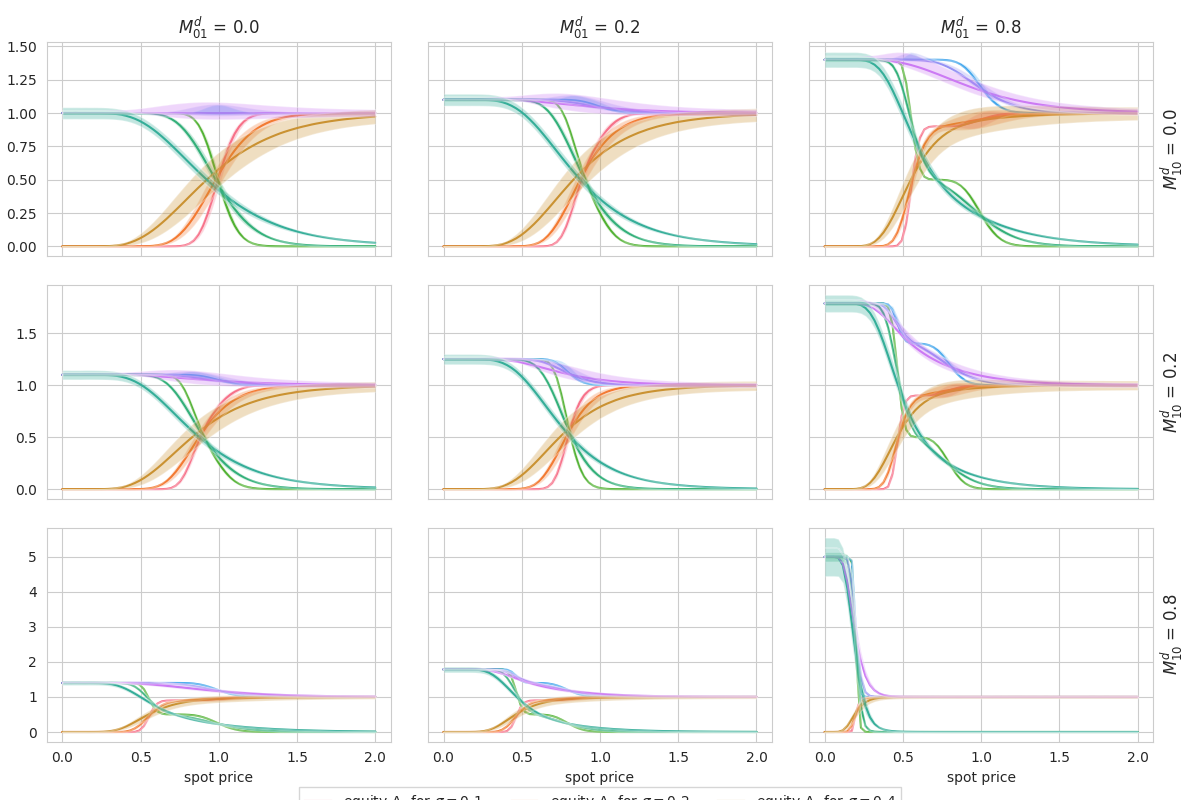

/home/jstobbe/ipcluster_1/ipcluster_1/lib/python3.6/site-packages/ipykernel_launcher.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/jstobbe/ipcluster_1/ipcluster_1/lib/python3.6/site-packages/ipykernel_launcher.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.


<IPython.core.display.Javascript object>


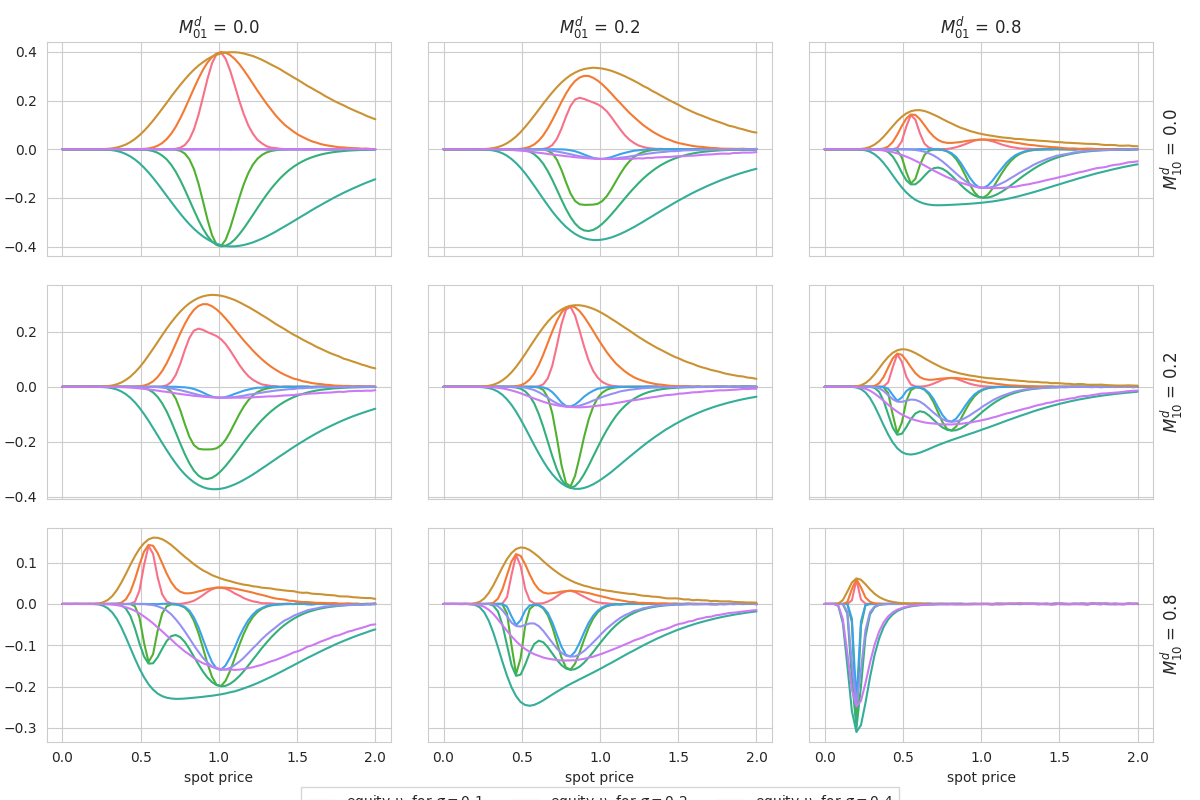

<IPython.core.display.Javascript object>


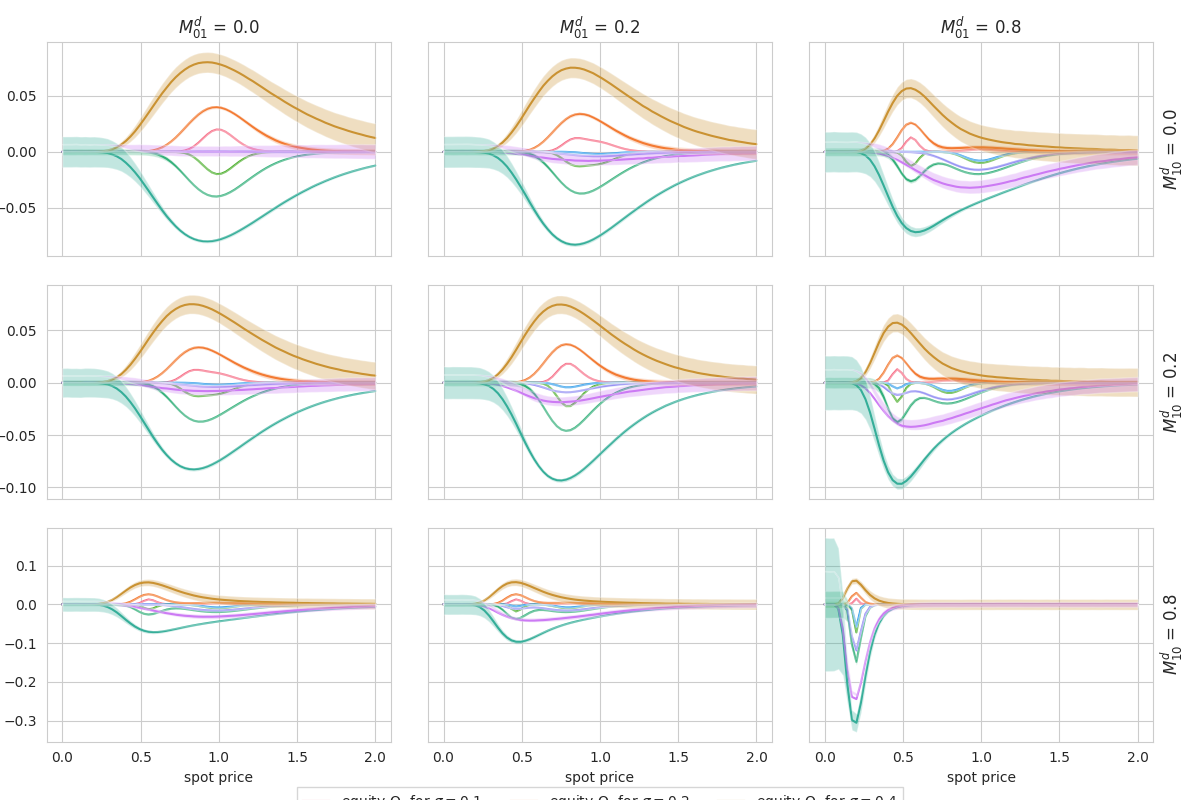

<IPython.core.display.Javascript object>


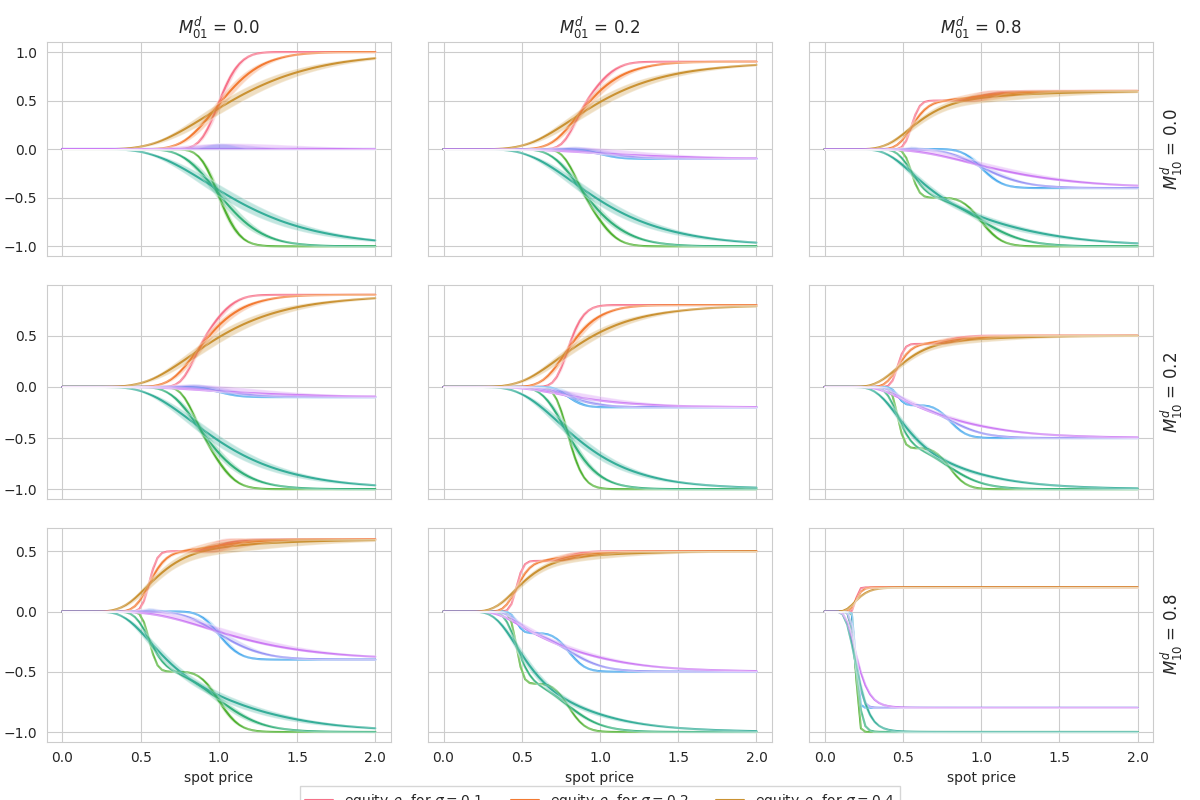

In [381]:
nplots = df2.index.levshape[5]
atl2 = S0
vr01l = np.unique(df_greeks.index.get_level_values('vr01').values)#np.unique(df1['vr10'].values)#np.linspace(0.,0.8, nplots)
vr10l = np.unique(df_greeks.index.get_level_values('vr10').values)#np.unique(df1['vs10'].values)#np.linspace(0.,0.8, nplots)
sigmal = np.unique(df_greeks.index.get_level_values('sigma').values)
sigmal = np.array([sigmal[0], sigmal[1], sigmal[-1]])
vr01l = np.array([vr01l[0],vr01l[1],vr01l[-1]])
vr10l = np.array([vr10l[0],vr10l[1],vr10l[-1]])
#d = 1.0
#tau = 1.0
#sigma = 0.1
#r = 0.2

cols = ['$M^d_{01}$' + ' = {0:.1f}'.format(col) for col in vr01l]
rows = ['$M^d_{10}$' + ' = {0:.1f}'.format(col) for col in vr10l]
greek_str = [r'$\Delta_s$',r'$\Delta_r$',r'$\Delta$', 
             r'$\nu_s$' ,  r'$\nu_r$' ,  r'$\nu$' ,
             r'$\Theta_s$',r'$\Theta_r$',r'$\Theta$',
             r'$\rho_s$',  r'$\rho_r$',  r'$\rho$']

var_r = True

for greek in range(4):
    f2, axarr2 = plt.subplots(len(vr01l),len(vr10l), figsize=(12, 8) ,sharex='col', sharey='row')
    for ax, col in zip(axarr2[0], cols):
        ax.set_title(col)
    for ax, col in zip(axarr2[-1], cols):
        ax.set_xlabel('spot price')
    for ax, row in zip(axarr2[:,-1], rows):
        ax.set_ylabel(row, rotation=90, size='large')
        ax.yaxis.set_label_position("right")
        
    f2.tight_layout()
    plt_lines = []
    color_lines = []
    str_lines = []
    for k,sigma_i in enumerate(sigmal):
        for i,vr01_val in enumerate(vr01l):
            for j,vr10_val in enumerate(vr10l):
            
                atl = S0
                gr = df_greeks.reset_index(level=1,drop=True).loc[sigmal[k],vr01_val, vr10_val].values
                gr_var = df_greeks_var.reset_index(level=1,drop=True).loc[sigmal[k],vr01_val, vr10_val].values
                gr_var = gr_var/(N*N)
                ind = 2*greek
                sline = axarr2[i,j].plot(atl,gr[:,ind], markersize=1, color=colors[k],zorder=1)
                ind = 2*greek+1
                rline = axarr2[i,j].plot(atl,gr[:,ind], markersize=1, color=colors[int(NColors/3)+k],zorder=1)
                vline = axarr2[i,j].plot(atl,gr[:,ind-1] + gr[:,ind],
                                         markersize=1, color=colors[int(2*NColors/3+k)],zorder=1) #

                if greek != 1:
                    ind = 2*greek
                    axarr2[i,j].fill_between(atl, gr[:,ind]+gr_var[:,ind], gr[:,ind]-gr_var[:,ind],
                                              facecolor=colors[k], alpha=0.3, zorder=2)
                    ind = 2*greek+1
                    axarr2[i,j].fill_between(atl, gr[:,ind]+gr_var[:,ind], gr[:,ind]-gr_var[:,ind],
                                              facecolor=colors[int(NColors/3+k)], alpha=0.3, zorder=2)
                    axarr2[i,j].fill_between(atl,gr[:,ind-1] + gr[:,ind]+(gr_var[:,ind-1]+gr_var[:,ind])/2,
                                             gr[:,ind-1] + gr[:,ind]-(gr_var[:,ind-1]-gr_var[:,ind])/2,
                                              facecolor=colors[int(2*NColors/3+k)], alpha=0.3, zorder=2)
        #    plt_linex.append((sline,rline,vline))
        color_lines += [colors[k], colors[int(NColors/3+k)], colors[int(2*NColors/3 + k)]]
        plt_lines += [sline, rline, vline]
        str_lines += ['equity '+greek_str[3*greek]+r' for $\sigma = $'+str(sigma_i), 
                      'debt '+greek_str[3*greek]+r' for $\sigma = $'+str(sigma_i), 
                      greek_str[3*greek]+r' for $\sigma = $'+str(sigma_i)]
    proxy_lines2 = [matplotlib.lines.Line2D([], [], color=p) for p in color_lines]
    lgd2 = f2.legend(proxy_lines2, str_lines,
                                loc='lower center', fancybox=False, shadow=False, ncol=3,
                                bbox_transform=f2.transFigure, bbox_to_anchor=(0.5,-0.09))
    #f2.legend((sline, rline, vline), ('equity', 'r', 'v = s+r'))
    f2.savefig('greeks_2D_'+str(greek)+'_varSigma.pdf', bbox_extra_artists=(lgd2,), bbox_inches="tight", format='pdf')
    del f2, axarr2#, proxy_lines2 #lgd2, 

<IPython.core.display.Javascript object>


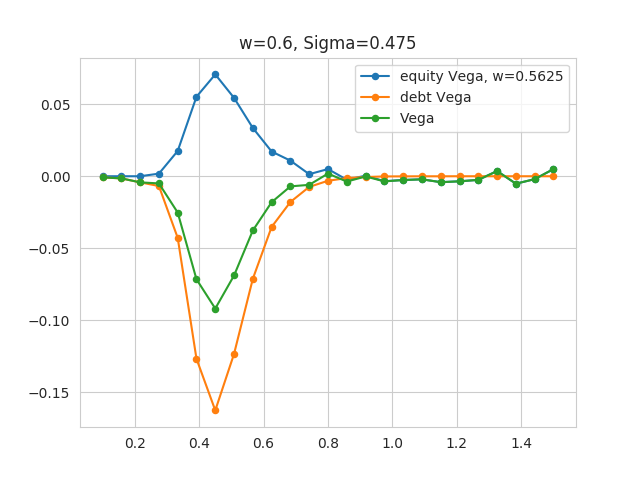

In [63]:
sns.set_style("whitegrid")
cmap = sns.color_palette("muted")#sns.cubehelix_palette(8, light=1)
ccycle = itertools.cycle(cmap)
#sns.set_palette(cmap)

def plot_val(l, ax, val, ds, S0, sigma, greek , title=""):
    nl = np.unique(l.reset_index(level=[1,2,3,4,5]).index.values)
    rl = np.unique(df1.reset_index()['r'])
    N = 2
    for r in rl:
        for w in col_sums[15:16]:
            c = next(ccycle)
            data = l.loc[idx[N, sigma ,w, ds, r, :],['equity ' + greek,'equity ' +greek+ ' var','debt '+greek,\
                                                  'debt '+greek+' var', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['Vega','Vega var', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['Solvent', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['RS', 'Number Of Samples']]
            n_samples = np.sqrt(np.array([ el for el in data['Number Of Samples'].values]))
            x = l.loc[idx[N, sigma, val, ds, r, :],:].reset_index([0,1,2,3,4]).index.values
            y = np.array([np.sum(el)/(float(N)) for el in data['equity '+greek].values])
            y2 = np.array([np.sum(el)/(float(N)) for el in data['debt '+greek].values])
            y3 = np.array([np.sum(el)/(float(N)) for el in data['debt '+greek].values+data['equity '+greek].values])
            #y_err = np.array([np.sqrt(np.sum(el)/float(N)) for el in data['Delta var'].values])/n_samples
            #y = np.array([np.sum(el[:N]+el[N:])/(float(N)) for el in data['RS'].values])
            #y = np.array([np.sum(el)/(float(N)) for el in data['Solvent'].values])
            #y = np.array([np.sum(el)/(float(N)) for el in data['Vega'].values])
            #y_err = np.array([np.sqrt(np.sum(el)/float(N)) for el in data['Vega var'].values])/n_samples
            ii = np.argsort(x)
            x = x[ii]
            y = y[ii]
            #y_err = y_err[ii]
            #sns.lineplot(x,y, ax = ax)
            ax.plot(x,y, marker='o', markersize=4.4, label="equity "+greek+", w=" + str(w))
            ax.plot(x,y2, marker='o', markersize=4.4, label="debt "+greek)
            ax.plot(x,y3, marker='o', markersize=4.4, label=greek)
            #ax.fill_between(x, y-y_err, y+y_err, color=c, alpha=0.4)
            if title:
                ax.set_title(title)
            else:
                ax.set_title(r'$\sum_j M_{ij} = $' + str(val) +" sigma " +str(sigma))
            ax.legend()
      
#fig, axs = plt.subplots(nrows=len(col_sums), ncols=len(sigma_vals), sharex=True, sharey=False, figsize=(7*len(df_scales), 10*len(col_sums)))
#for ic, val in enumerate(col_sums):
#    for ir, sp in enumerate(sigma_vals):
#        ax = axs[ic,ir]
fix, ax = plt.subplots(nrows = 1, ncols = 1)
val = 0.6
sp = sigma_vals[3]
greek = "Vega"
plot_val(df1 ,ax, val, 1.0, -1, sp, greek ,"w=" + str(val) + ", Sigma=" + str(sp))

#axs[0,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[1,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[2,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[2,0].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#axs[2,1].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#plt.errorbar(x, y, yerr=y_err, fmt='o')

plt.show()

In [189]:
np.unique(df1.reset_index([0,1,2,3,4,5])['col sum'])   #r, S0, default scale, col sum

array([0.1, 0.3, 0.5, 0.7])

In [ ]:
#res = [r.get() for r in async_res]
results = []
res = res_0_4
tmp = combine_results(*res)
results.append(tmp[0])
while len(tmp[1]):
    tmp = combine_results(*tmp[1])
    results.append(tmp[0])
results[1]